In [12]:
# Standars libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import pickle
import itertools as it
from collections import Counter
import pyspark
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
#import country_converter as coco

import spacy

from os import path
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
import re

import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 400)


START_DATE = '2019-12-12'
END_DATE = '2020-04-09'

coronavirus = "coronavirus,covid,covid-19,corona,pandémie,virus, pandemie".lower().split(',')#pandémie,virus

Python version
3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
Version info.
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


In [35]:
import pandas as pd
import glob

path = r'/mnt/datastore/data/antivax/timelines' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

antivax_df = pd.concat(li, axis=0, ignore_index=True)
antivax_df = antivax_df[~antivax_df['created_at'].isna()]
antivax_df.head(3)

,tweet_id,user_id,user_name,followers,friends,user_location,likes,retweets,text,created_at,urls
0,1064867712890019841,1328937145,Predatoutheures,53.0,273.0,NaN,0.0,0.0,@immoboum ET SI... L'on s'occupait des Banques Françaises dans le cadre des évasions fiscales juste pour retrouver l'équité entre le Vulgum Pecus et la Justice de la République comme ça juste pour voir...!!! A BON ENTENDEUR https://t.co/zcuY5nDjKE,Tue Nov 20 13:07:01 +0000 2018,[]
1,1064866076511617026,1328937145,Predatoutheures,53.0,273.0,NaN,0.0,0.0,@20Minutes Ce n'est pas les ATTENTATS que le Gouvernement doit craindre c'est la COLERE des Français et lorsque les Français sont en colère LA VEUVE PLEURE A NOUVEAU DU SANG...A BON ENTENDEUR...AH au fait je suis toujours à la même adresse les Zonzons et autres mais vous savez cela Non..! https://t.co/jSsyIqf1OE,Tue Nov 20 13:00:31 +0000 2018,[]
2,1064864589119176705,1328937145,Predatoutheures,53.0,273.0,NaN,0.0,0.0,"@lacavapeter VOILA CA C'est la France... Liberté- Egalité-Fraternité le Pays des Droits de l'homme, et Homme est au Singulier cela veut tout dire ...!!! A BON ENTENDEUR https://t.co/1kVRBlCW7S",Tue Nov 20 12:54:36 +0000 2018,[]


Text(0.5, 1.0, 'Number of tweet by antivax accounts')

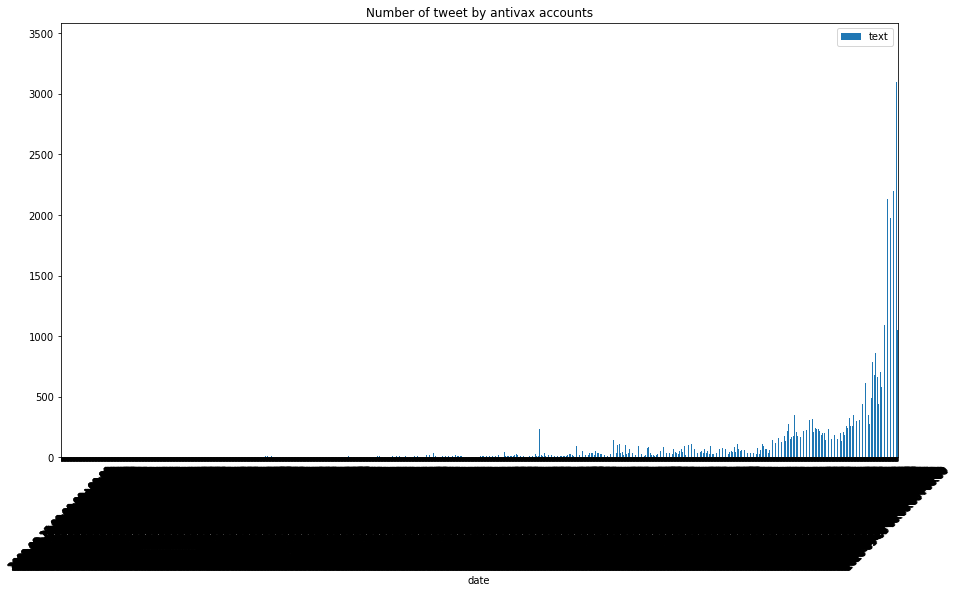

In [38]:
antivax_df['date'] = pd.to_datetime(antivax_df['created_at'], errors='coerce')

antivax_count = antivax_df.resample('D', on='date').agg({'text':'count'})
antivax_count[['text']].plot(kind='bar', figsize=(15, 8))
plt.xticks(rotation=45)
plt.title('Number of tweet by antivax accounts')

In [39]:
print(antivax_df.text.str.contains('#').count())
antivax_df['hashtags'] = antivax_df.text.str.findall('#([A-Za-z0-9]+)')
antivax_df['hashtags'].explode().str.lower().value_counts().head(100)

346002


coronavirus                4249
macron                     3613
covid19                    3051
giletsjaunes               2315
covid                      2076
sant                       1493
france                     1446
ogm                        1427
vaccins                    1072
globaldebout               1044
paris                       874
frexit                      840
chloroquine                 802
confinement                 787
hellohellofrance            780
marseille                   733
politiqueinternationale     728
nddl                        676
lrem                        660
loitravail                  596
nuitdebout                  595
m                           584
bio                         582
social                      574
pesticides                  565
raoult                      561
monsanto                    533
glyphosate                  532
franceinfo                  531
d                           530
politiqueint                519
libert  

In [41]:
import re
import nltk

#nltk.download('stopwords')
#nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

stop_words = set(stopwords.words("english"))

##Creating a list of custom stopwords
new_words = ["rss", "extrait", "source", "auteur", "shared", "items", "on", "the", "old", "reader", "jt", "lundi", "mardi", "mercredi", "jeudi", "vendredi", "samedi", "dimanche"]
stop_words = stop_words.union(new_words)

nlp = spacy.load("en_core_web_sm")

# Clean and prepare the titles for processing
def generateCorpus(sentences, stop_words):
    corpus = []
    for i, title in enumerate(sentences):
        title = title.replace("\n", " ")
        
        print(str(i + 1) + "/" + str(len(sentences)) + "\r", end="")
        text = []
        doc = nlp(title)
        for token in doc:
            #Remove punctuations, digits and special characters and Lemmatize
            if token.is_alpha and not token.is_stop and not token.text.lower() in stop_words: 
                if token.text.lower() == 'coronavirus':
                    text.append(token.text)
                else:
                    text.append(token.lemma_)
                
        #Convert to lowercase
        text = " ".join(text).lower()

        corpus.append(text)
    return corpus

#Most frequently occuring words
def get_top_n_words(corpus, top_n=None, ngram_range=(1, 1)):   
    vec = CountVectorizer(ngram_range=ngram_range,  
            max_features=2000).fit(corpus) 
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:top_n]

from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import coo_matrix

# Top keywords with IDF FT
def get_idf_transformer(corpus, stop_words):
    

    cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,1))
    X=cv.fit_transform(corpus)
    
    # get feature names
    feature_names=cv.get_feature_names()

    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(X)
    
    return tfidf_transformer, feature_names, cv

def get_keywords(tfidf_transformer, feature_names, cv, doc, top_n, stop_words): 
    doc = generateCorpus([doc], stop_words)[0]
    
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

    #Function for sorting tf_idf in descending order
    coo_matrix = tf_idf_vector.tocoo()
    sorted_items = zip(coo_matrix.col, coo_matrix.data) 
    sorted_items = sorted(sorted_items, key=lambda x: (x[1], x[0]), reverse=True)

    #use only topn items from vector
    sorted_items = sorted_items[:top_n]

    score_vals = []
    feature_vals = []

    # word index and corresponding tf-idf score
    for idx, score in sorted_items:

        #keep track of feature name and its corresponding score
        score_vals.append(score)
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    keywords= {}
    for idx in range(len(feature_vals)):
        keywords[feature_vals[idx]]=score_vals[idx]
    return keywords

corpus = generateCorpus(antivax_df.text.values, stop_words)
tfidf_transformer, feature_names, cv = get_idf_transformer(corpus, stop_words)


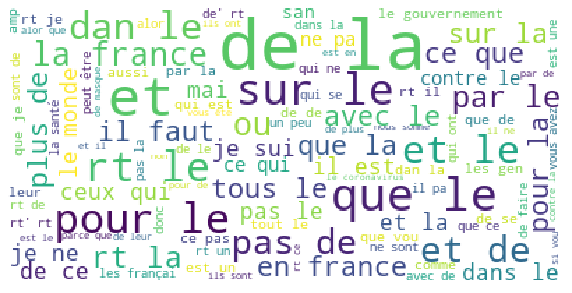

In [42]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#Word cloud
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
fig = plt.figure(1, figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#fig.savefig("word1.png", dpi=900)

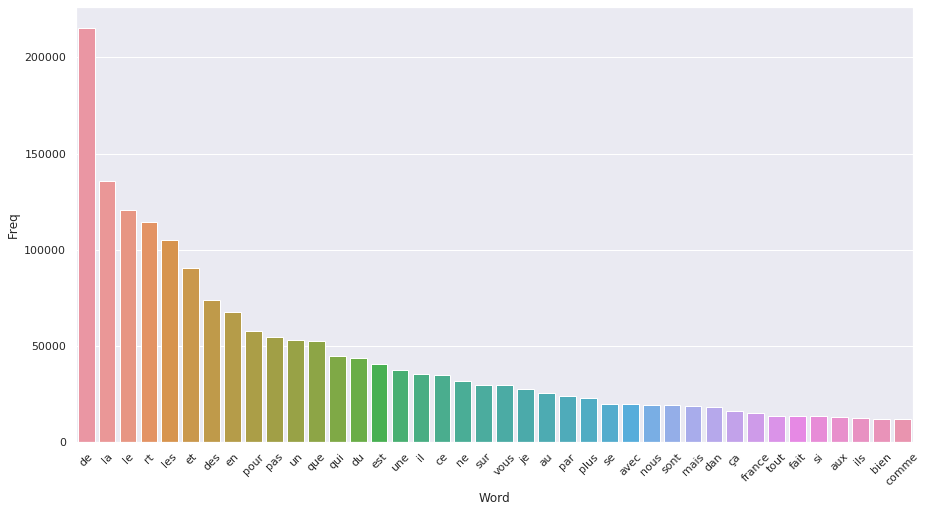

In [43]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, top_n=40)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

#Barplot of most freq words
sns.set(rc={'figure.figsize':(15,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show()

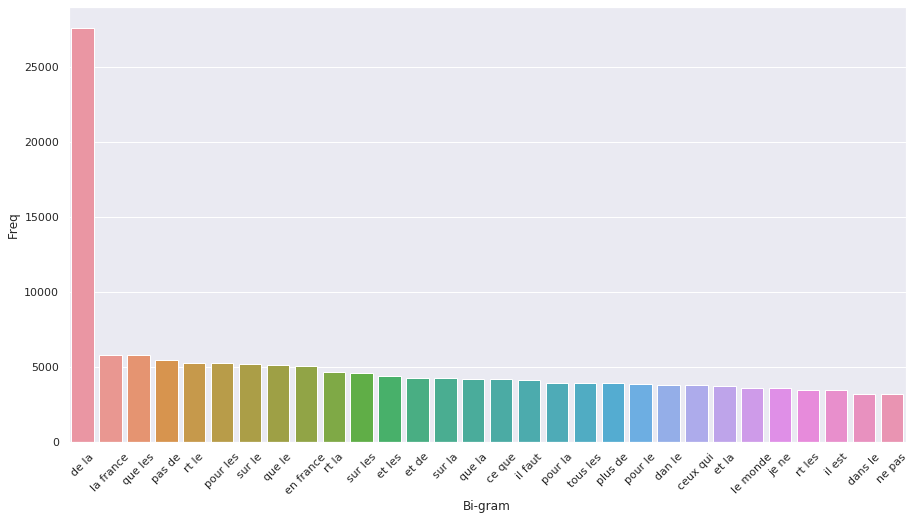

In [44]:
#Most frequently occuring Bi-grams
top2_words = get_top_n_words(corpus, top_n=30, ngram_range=(2, 2))
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(15,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)
plt.show()

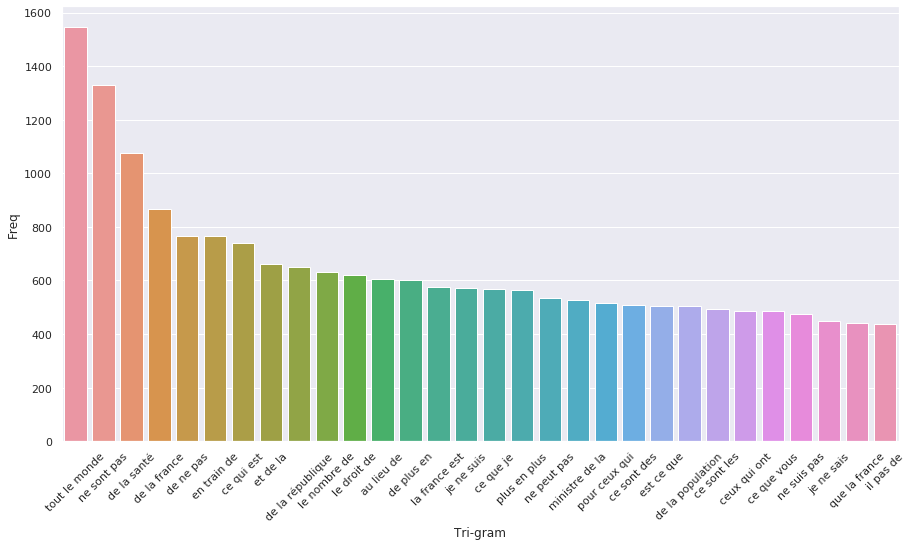

In [45]:
#Most frequently occuring Tri-grams
top3_words = get_top_n_words(corpus, top_n=30, ngram_range=(3, 3))
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)
plt.show()